# Importing relevant libraries and data required

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('G:\\virtual experience\\Quantium\\QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


# Select control stores 77, 86, 88

The client want control stores to be established stores that are operational for the entire observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of:

    Monthly overall sales revenue
    Monthly number of customers
    Monthly number of transactions per customer

Let's first create the metrics of interest and filter out stores that are present throughout the pre-trial period.

In [4]:
data["DATE"] = pd.to_datetime(data["DATE"])
data["YEARMONTH"] = data["DATE"].dt.strftime("%Y%m").astype("int")

For each month and store, calculate:

    Total sales
    Number of customers
    Transaction per customer
    Chips per transaction
    Average price per unit

In [56]:
def monthly_store_details():
    total_sales = data.groupby(['STORE_NBR', 'YEARMONTH']).TOT_SALES.sum()
    num_cust = data.groupby(['STORE_NBR', 'YEARMONTH']).LYLTY_CARD_NBR.nunique()
    trans_per_cust = data.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique() / data.groupby(['STORE_NBR', 'YEARMONTH']).LYLTY_CARD_NBR.nunique()
    avg_chips_per_cust = data.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum() / data.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique()
    avg_chips_price = data.groupby(['STORE_NBR', 'YEARMONTH']).TOT_SALES.sum() / data.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum()
    aggregates = [total_sales, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    details = pd.concat(aggregates, join="outer", axis=1)
    details.columns = ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return details

In [57]:
store_df = monthly_store_details().reset_index()
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
STORE_NBR          3169 non-null int64
YEARMONTH          3169 non-null int64
TOT_SALES          3169 non-null float64
nCustomers         3169 non-null int64
nTxnPerCust        3169 non-null float64
nChipsPerTxn       3169 non-null float64
avgPricePerUnit    3169 non-null float64
dtypes: float64(4), int64(3)
memory usage: 173.4 KB


In [65]:
df_count = store_df["STORE_NBR"].value_counts()
full_index = df_count[df_count == 12].index
full_observ = store_df[store_df["STORE_NBR"].isin(full_index)]
full_store_df = full_observ[full_observ["YEARMONTH"] < 201902]

full_store_df

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549
3160,272,201810,430.6,44,1.136364,1.980000,4.349495
3161,272,201811,376.2,41,1.097561,1.933333,4.324138
3162,272,201812,403.9,47,1.000000,1.893617,4.538202


In [73]:
# Creating a function which calculates the correlation between trial store and other stores based on a single metric

def calCorr(metric, trial_store, inputTable = full_store_df):
    
    ctrl_store = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    output = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
    store_comp = inputTable[inputTable['STORE_NBR'] == trial_store][metric].reset_index()
    
    for i in ctrl_store:
        concat_df = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
        control_store = inputTable[inputTable['STORE_NBR'] == i][metric].reset_index()
        control_store.reset_index(drop = True, inplace = True)
        concat_df["Corr_Score"] = store_comp.corrwith(control_store, axis=1)
        concat_df["Trial_Str"] = trial_store
        concat_df["Ctrl_Str"] = i
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == trial_store]["YEARMONTH"])
        output = pd.concat([output, concat_df])
    return output


In [76]:
corr_table = pd.DataFrame()
for store in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calCorr(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], store)])
    
corr_table.head(10)

,YEARMONTH,Trial_Str,Ctrl_Str,Corr_Score
0,201807,77,1,0.070544
1,201808,77,1,0.027332
2,201809,77,1,0.002472
3,201810,77,1,-0.019991
4,201811,77,1,0.030094
5,201812,77,1,0.064176
6,201901,77,1,0.001586
0,201807,77,2,0.143089
1,201808,77,2,0.097781
2,201809,77,2,0.078056


In [77]:
def calMagDist(metric, trial_store, inputTable=full_store_df):
    
    ctrl_store = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    store_comp = inputTable[inputTable["STORE_NBR"] == trial_store][metric]
    for i in ctrl_store:
        concat_df  = abs(inputTable[inputTable["STORE_NBR"] == trial_store].reset_index()[metric] - inputTable[inputTable["STORE_NBR"] == i].reset_index()[metric])
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == trial_store]["YEARMONTH"])
        concat_df["Trial_Str"] = trial_store
        concat_df["Ctrl_Str"] = i
        dists = pd.concat([dists, concat_df])
    for col in metric:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metric].mean(axis=1)
    return dists

In [79]:
dist_table = pd.DataFrame()
for store in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calMagDist(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], store)])
    
dist_table

,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,YEARMONTH,Trial_Str,Ctrl_Str,magnitude
0,0.935431,0.980769,0.956123,0.522259,0.883569,201807,77,1,0.855630
1,0.942972,0.951923,0.993541,0.592305,0.886328,201808,77,1,0.873414
2,0.961503,0.836538,0.991768,0.456272,0.703027,201809,77,1,0.789822
3,0.988221,0.932692,0.989036,0.886568,0.590528,201810,77,1,0.877409
4,0.962149,0.951923,0.868852,0.557921,0.832481,201811,77,1,0.834665
...,...,...,...,...,...,...,...,...,...
2,0.207554,0.286822,0.469697,0.948729,0.923887,201809,88,272,0.567338
3,0.346797,0.387597,0.534816,0.943478,0.971133,201810,88,272,0.636764
4,0.286706,0.310078,0.615078,0.923475,0.966999,201811,88,272,0.620467
5,0.347151,0.387597,0.343915,0.884572,0.962198,201812,88,272,0.585087


In [80]:
def combine_metric(metric, trial_store, inputTable=full_store_df):
    corrs = calCorr(metric, trial_store, inputTable)
    dists = calMagDist(metric, trial_store, inputTable)
    dists = dists.drop(metric, axis=1)
    combine = pd.merge(corrs, dists, on=["YEARMONTH", "Trial_Str", "Ctrl_Str"])
    return combine

In [81]:
compare_metrics_table1 = pd.DataFrame()
for store in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_metric(["TOT_SALES"], store)])

In [82]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

In [83]:
#Top 5 Score for each Trial Store wrt SALES
grouped_comparison_table1 = compare_metrics_table1.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table1["CompScore"] = (corr_weight * grouped_comparison_table1["Corr_Score"]) + (dist_weight * grouped_comparison_table1["magnitude"])
for trial_num in compare_metrics_table1["Trial_Str"].unique():
    print(grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
218         77       233         1.0   0.986477   0.993238
239         77       255         1.0   0.979479   0.989739
177         77       188         1.0   0.977663   0.988831
49          77        53         1.0   0.976678   0.988339
120         77       131         1.0   0.976267   0.988134 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
356         86       109         1.0   0.966783   0.983391
401         86       155         1.0   0.965876   0.982938
464         86       222         1.0   0.962280   0.981140
467         86       225         1.0   0.960512   0.980256
471         86       229         1.0   0.951704   0.975852 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
551         88        40         1.0   0.941165   0.970582
538         88        26         1.0   0.904377   0.952189
582         88        72         1.0   0.903800   0.951900
517         88         4         1.0   0.903466   0.

In [84]:
compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_metric(["nCustomers"], trial_num)])
    
#Top 5 highest Composite Score for each Trial Store based wrt Customers
grouped_comparison_table2 = compare_metrics_table2.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table2["CompScore"] = (corr_weight * grouped_comparison_table2["Corr_Score"]) + (dist_weight * grouped_comparison_table2["magnitude"])
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    print(grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
218         77       233         1.0   0.993132   0.996566
38          77        41         1.0   0.976648   0.988324
101         77       111         1.0   0.968407   0.984203
105         77       115         1.0   0.967033   0.983516
15          77        17         1.0   0.965659   0.982830 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
401         86       155         1.0   0.986772   0.993386
467         86       225         1.0   0.969577   0.984788
356         86       109         1.0   0.969577   0.984788
471         86       229         1.0   0.964286   0.982143
293         86        39         1.0   0.961640   0.980820 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
736         88       237         1.0   0.987818   0.993909
705         88       203         1.0   0.944629   0.972315
551         88        40         1.0   0.942414   0.971207
668         88       165         1.0   0.935770   0.

In [85]:
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    a = grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    b = grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    print((pd.concat([a,b], axis=1).sum(axis=1)/2).sort_values(ascending=False).head(3), '\n')

Trial_Str  Ctrl_Str
77         233         0.994902
           41          0.986020
           46          0.984762
dtype: float64 

Trial_Str  Ctrl_Str
86         155         0.988162
           109         0.984090
           225         0.982522
dtype: float64 

Trial_Str  Ctrl_Str
88         40          0.970895
           26          0.958929
           72          0.954079
dtype: float64 



Based on highest average of both features combined:

    Trial store 77: Store 233
    Trial store 86: Store 155
    Trial store 88: Store 40

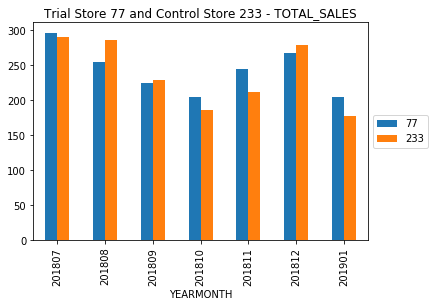

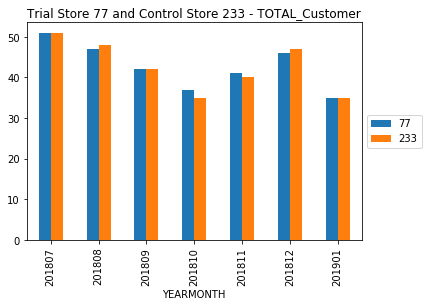

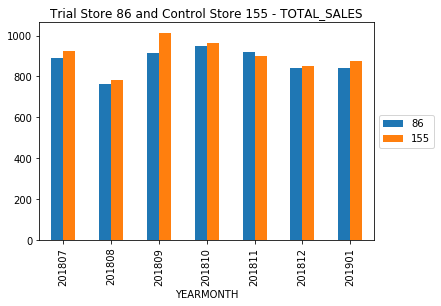

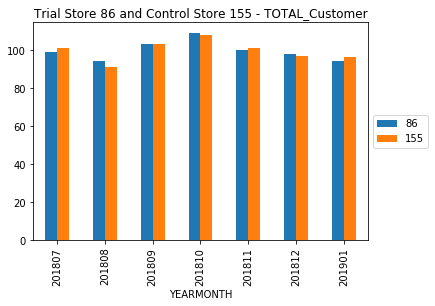

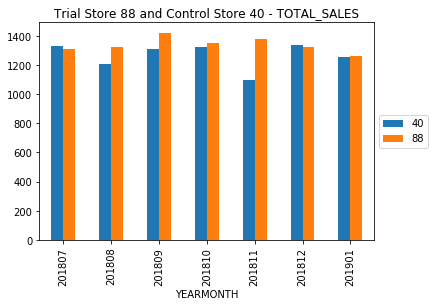

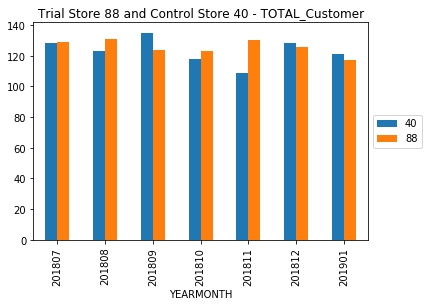

In [87]:
trial_control = {77:233, 86:155, 88:40}
for key, val in trial_control.items():
    full_store_df[full_store_df["STORE_NBR"].isin([key, val])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["TOT_SALES"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - TOTAL_SALES")
    plt.show()
    full_store_df[full_store_df["STORE_NBR"].isin([key, val])].groupby(
    ["YEARMONTH", "STORE_NBR"]).sum()["nCustomers"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - TOTAL_Customer")
    plt.show()
    print('\n')

Next we'll compare the performance of Trial stores to Control stores during the trial period.

In [88]:
#Ratio of Store 77 and its Control store.
sales_ratio_77 = full_store_df[full_store_df["STORE_NBR"] == 77]["TOT_SALES"].sum() / full_store_df[full_store_df["STORE_NBR"] == 233]["TOT_SALES"].sum()

#Ratio of Store 86 and its Control store.
sales_ratio_86 = full_store_df[full_store_df["STORE_NBR"] == 86]["TOT_SALES"].sum() / full_store_df[full_store_df["STORE_NBR"] == 155]["TOT_SALES"].sum()

#Ratio of Store 77 and its Control store.
sales_ratio_88 = full_store_df[full_store_df["STORE_NBR"] == 88]["TOT_SALES"].sum() / full_store_df[full_store_df["STORE_NBR"] == 40]["TOT_SALES"].sum()

In [89]:
trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_sales_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]

def scaler(row):
    if row["STORE_NBR"] == 233:
        return row["TOT_SALES"] * sales_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["TOT_SALES"] * sales_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["TOT_SALES"] * sales_ratio_88

scaled_sales_control_stores["ScaledSales"] = scaled_sales_control_stores.apply(lambda row: scaler(row), axis=1)

trial_scaled_sales_control_stores = scaled_sales_control_stores[(scaled_sales_control_stores["YEARMONTH"] >= 201902) & (scaled_sales_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_sales_control_stores = scaled_sales_control_stores[scaled_sales_control_stores["YEARMONTH"] < 201902]

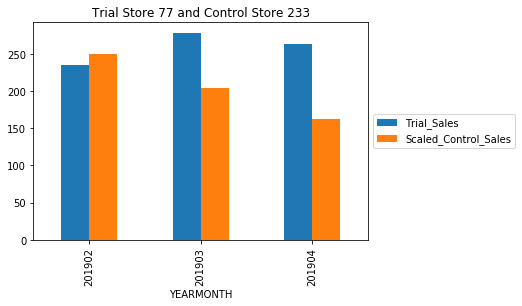

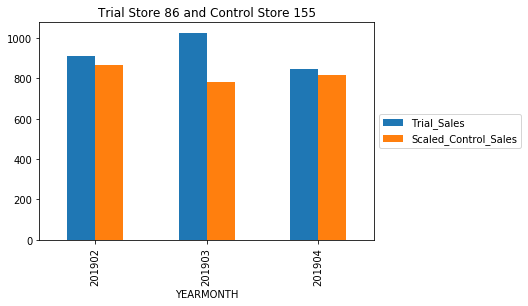

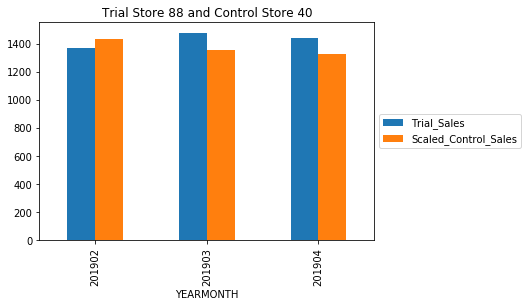

In [91]:
percentage_diff = {}

for trial, control in trial_control.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]
    percentage_diff[trial] = b["TOT_SALES"].sum() / a["ScaledSales"].sum()
    b[["YEARMONTH", "TOT_SALES"]].merge(a[["YEARMONTH", "ScaledSales"]],on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales":"Scaled_Control_Sales", "TOT_SALES":"Trial_Sales"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))